In [49]:
## IMPORT RELEVANT LIBRARIES
import time
import torch
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.optim import lr_scheduler

In [53]:
### training parameters
SHOW_SAMPLES = True
BATCH_SIZE = 32
NUM_CLASSES = 10
LEARNING_RATE = 3e-4
NUM_EPOCHS = 10
PRINT_INTERVAL = 200*(32/BATCH_SIZE) ## frequency of prining training stats
VAL_INTERVAL = 200*(32/BATCH_SIZE) ### frequency of validation in terms of train iterations
SMOOTHING_FACTOR = 0.90 ### for prining the running loss
OPTIMIZER = "adam" ### adam or SGD
LOSS_FUNCTION = "KLDivergence" ## KLDivergence or CrossEntropy
DATA_AUGMENTATION = False
LR_SCHEDULER = False

In [54]:
### DATA LOADING
### statistics for the CIFAR10 dataset
torch.manual_seed(0)

cifar_mean, cifar_std = [0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616]
### cifar
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

if(not DATA_AUGMENTATION):
  transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize(mean=cifar_mean, std = cifar_std)]) 
else:
  transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.25), 
                                  transforms.RandomVerticalFlip(p=0.25),
                                  transforms.RandomRotation(degrees=(-30,30)),
                                  transforms.GaussianBlur(kernel_size=(3,3), sigma=(0.1, 0.25)),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=cifar_mean, std=cifar_std)])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Images: torch.Size([32, 3, 32, 32]), Labels: torch.Size([32])


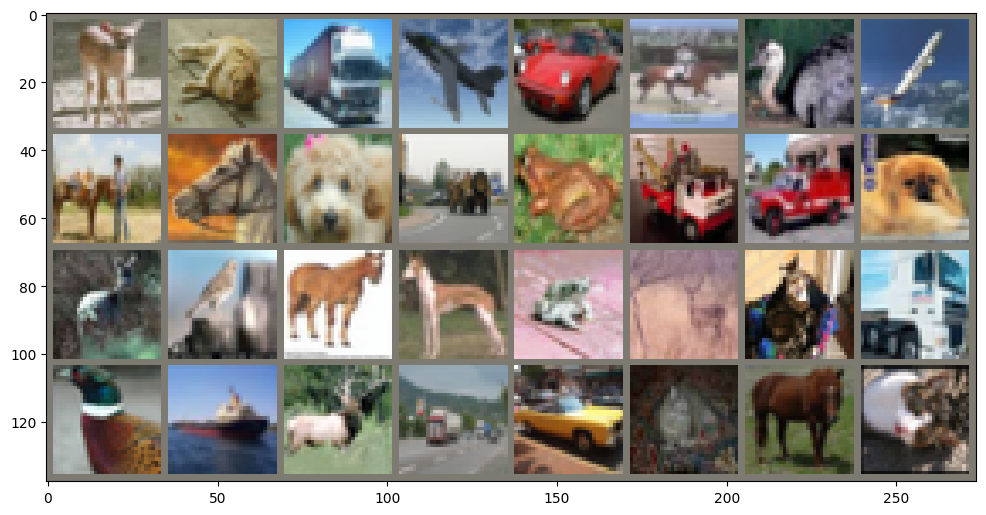

deer cat truck plane car horse bird plane horse horse dog truck frog truck truck dog deer bird horse dog frog deer cat truck bird ship deer truck car cat horse cat


In [55]:
### Show Image Samples

def imshow(img):
    plt.figure(figsize=(12,8))
    npimg = img.numpy()
    npimg = npimg * np.array(cifar_std).reshape(-1,1,1) + np.array(cifar_mean).reshape(-1,1,1) ### un-normalize
    plt.imshow(np.transpose(npimg, (1, 2, 0))) ### to put channels last according to matplotlib
    plt.show()
    
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(f"Images: {images.shape}, Labels: {labels.shape}") ### B * C * H * W, B

if SHOW_SAMPLES:
    imshow(torchvision.utils.make_grid(images))
    print(" ".join([classes[j] for j in labels]))

In [56]:
## NETWORK CONFIG

class ConvNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), stride=1, padding="valid")
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2))
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), stride=1, padding="valid")
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2))
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=1, padding="valid")
        self.fc1 = nn.Linear(3*3*64, 64)
        self.fc2 = nn.Linear(64, NUM_CLASSES)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1, end_dim=-1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [57]:
### initialize model, optimizers and the loss function and settup GPU 

model = ConvNet()

## LOSS FUNCTION
if(LOSS_FUNCTION == "KLDivergence"):
  criterion = nn.KLDivLoss(reduction = "batchmean")
elif(LOSS_FUNCTION == "CrossEntropy"):
  criterion = nn.CrossEntropyLoss()
else:
  raise ValueError("LOSS FUNCTION has to be one of KLDivergence | CrossEntropy")

## OPTIMIZER
if (OPTIMIZER == "SGD"):
  optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
elif (OPTIMIZER == "adam"):
  optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999), eps=1e-08)
else:
  raise ValueError("Optimizer has to be one of SGD | Adam")

### scheduling algorithm
if(LR_SCHEDULER):
  scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7, verbose=True)
else:
  ## has effect of no scheduling
  scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=1, verbose=True)

is_cuda = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(is_cuda)
print(device)
model.to(device)

Adjusting learning rate of group 0 to 3.0000e-04.
cuda


ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=valid)
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (fc1): Linear(in_features=576, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

In [58]:
### TRAINING LOOP
start = time.time()
smooth_training_loss_list_per_iteration = [] ## batch loss after every update
training_loss_list_per_iteration = []
validaton_loss_list_per_iteration = [] ## average validation loss after every VAL_INTERVAL updates
validation_accuracy_per_iteration = []
val_iterations = []
training_accuracy_vs_epoch = []
total_iterations  = 0

for epoch in range(NUM_EPOCHS):
    
    training_running_loss, training_correct = 0.0, 0
    model.train()
    for batch_idx, data in enumerate(trainloader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(images)
        if(LOSS_FUNCTION == "CrossEntropy"):
          loss = criterion(logits, labels)
        elif(LOSS_FUNCTION == "KLDivergence"):
          smoothened_target = F.one_hot(labels, num_classes=NUM_CLASSES)*.999 + .0001 * torch.ones((labels.shape[0], NUM_CLASSES), device=device)
          loss = criterion(F.log_softmax(logits, dim=1), smoothened_target)

        loss.backward()
        optimizer.step()
        training_running_loss = (loss.item()) if batch_idx == 0 else (loss.item() * (1-SMOOTHING_FACTOR) + SMOOTHING_FACTOR*training_running_loss)
        training_correct += torch.sum(torch.argmax(logits, dim=1) == labels).item()
        smooth_training_loss_list_per_iteration.append(training_running_loss)
        training_loss_list_per_iteration.append(loss.item())
        total_iterations += 1

        if( batch_idx % PRINT_INTERVAL == PRINT_INTERVAL-1 ):
            print(f"\r[TRAIN STAT] Epoch:Iter => {epoch+1}:{batch_idx+1:05} | Running Loss => {training_running_loss:.3f}")
        
        ### TESTING ACCURACY & LOSS
        if(total_iterations % VAL_INTERVAL == VAL_INTERVAL - 1):
          # print("Validation ... ")
          testing_correct = 0.0
          temp_list = []
          for batch_idx, data in enumerate(testloader):
              images, labels = data
              images, labels = images.to(device), labels.to(device)
              logits = model(images)
              if(LOSS_FUNCTION == "CrossEntropy"):
                loss = criterion(logits, labels)
              elif(LOSS_FUNCTION == "KLDivergence"):
                smoothened_target = F.one_hot(labels, num_classes=NUM_CLASSES)*.999 + .0001 * torch.ones((labels.shape[0], NUM_CLASSES), device=device)
                loss = criterion(F.log_softmax(logits, dim=1), smoothened_target)
              temp_list.append(loss.item())
              testing_correct += torch.sum(torch.argmax(logits, dim=1) == labels).item()

          validaton_loss_list_per_iteration.append(sum(temp_list)/len(temp_list))
          validation_accuracy_per_iteration.append(testing_correct/len(testset)*100)
          val_iterations.append(total_iterations)
    
    scheduler.step()

    model.eval()
    training_correct = 0 
    for batch_idx, data in enumerate(trainloader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        training_correct += torch.sum(torch.argmax(logits, dim=1) == labels).item()
    training_accuracy_vs_epoch.append(training_correct/len(trainset)*100)
    print(f"Epoch: {epoch+1} END | TRAINING ACCURACY: {training_correct/len(trainset)*100:.2f}% | TESTING ACCURACY: {testing_correct/len(testset)*100:.2f}%")

end = time.time()
print(f"Time Taken {(end-start):.2f} seconds")
print("Finished Training ... ")

[TRAIN STAT] Epoch:Iter => 1:00200 | Running Loss => 1.836
[TRAIN STAT] Epoch:Iter => 1:00400 | Running Loss => 1.728
[TRAIN STAT] Epoch:Iter => 1:00600 | Running Loss => 1.550
[TRAIN STAT] Epoch:Iter => 1:00800 | Running Loss => 1.462
[TRAIN STAT] Epoch:Iter => 1:01000 | Running Loss => 1.444
[TRAIN STAT] Epoch:Iter => 1:01200 | Running Loss => 1.354
[TRAIN STAT] Epoch:Iter => 1:01400 | Running Loss => 1.315
Adjusting learning rate of group 0 to 3.0000e-04.
Epoch: 1 END | TRAINING ACCURACY: 52.21% | TESTING ACCURACY: 52.26%
[TRAIN STAT] Epoch:Iter => 2:00200 | Running Loss => 1.227
[TRAIN STAT] Epoch:Iter => 2:00400 | Running Loss => 1.253
[TRAIN STAT] Epoch:Iter => 2:00600 | Running Loss => 1.181
[TRAIN STAT] Epoch:Iter => 2:00800 | Running Loss => 1.270
[TRAIN STAT] Epoch:Iter => 2:01000 | Running Loss => 1.174
[TRAIN STAT] Epoch:Iter => 2:01200 | Running Loss => 1.198
[TRAIN STAT] Epoch:Iter => 2:01400 | Running Loss => 1.207
Adjusting learning rate of group 0 to 3.0000e-04.
Epoch:

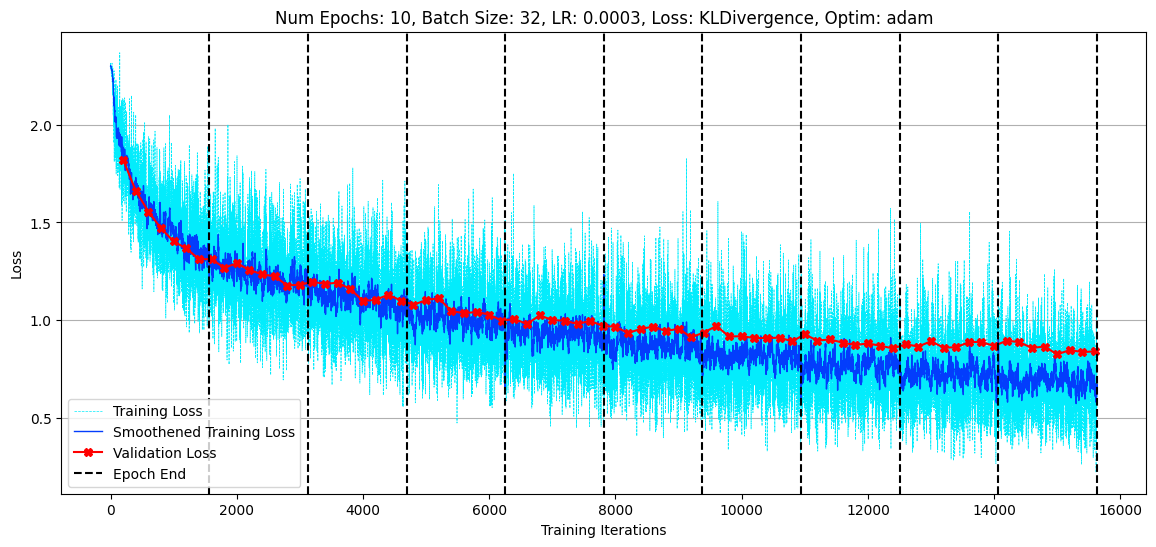

In [59]:
### PLOTS
plt.figure(figsize=(14, 6))
plt.plot([min(i,3) for i in training_loss_list_per_iteration], label="Training Loss", color = "#03ecfc", lw = 0.5, ls="--")
plt.plot(smooth_training_loss_list_per_iteration, label = "Smoothened Training Loss", color = "#033dfc", lw=1)
plt.plot(val_iterations, validaton_loss_list_per_iteration , label="Validation Loss", marker = "X", color="red")
for i in range(NUM_EPOCHS):
  label = ("Epoch End" if i == NUM_EPOCHS - 1 else None )
  plt.axvline(len(trainloader)*(i+1), 0, max(training_loss_list_per_iteration), color="black", ls = "--", label=label)
plt.ylabel("Loss")
plt.xlabel("Training Iterations")
plt.title(f"Num Epochs: {NUM_EPOCHS}, Batch Size: {BATCH_SIZE}, LR: {LEARNING_RATE}, Loss: {LOSS_FUNCTION}, Optim: {OPTIMIZER}")
plt.legend()
plt.gca().yaxis.grid(True)
# plt.grid(True)
plt.show()

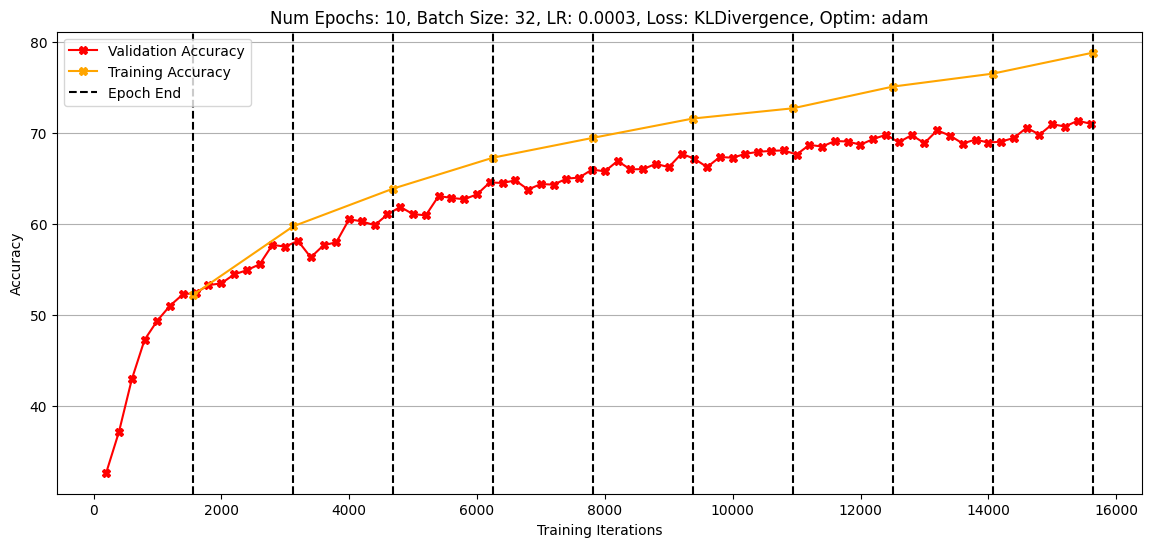

In [60]:
plt.figure(figsize=(14,6))
plt.plot(val_iterations, validation_accuracy_per_iteration , label="Validation Accuracy", marker = "X", color="red")
plt.plot([len(trainloader)*(i+1) for i in range(NUM_EPOCHS)], training_accuracy_vs_epoch, label="Training Accuracy", marker = "X", color="Orange")
for i in range(NUM_EPOCHS):
  label = ("Epoch End" if i == NUM_EPOCHS - 1 else None )
  plt.axvline(len(trainloader)*(i+1), 0, 100, color="black", ls = "--", label=label)
plt.xlabel("Training Iterations")
plt.ylabel("Accuracy")
plt.title(f"Num Epochs: {NUM_EPOCHS}, Batch Size: {BATCH_SIZE}, LR: {LEARNING_RATE}, Loss: {LOSS_FUNCTION}, Optim: {OPTIMIZER}")
plt.gca().yaxis.grid(True)
plt.legend()

In [61]:
def class_wise_accuracy(model, dataloader):
  model.eval()
  total_cnt = [0 for _ in range(NUM_CLASSES)]
  correct_cnt = [0 for _ in range(NUM_CLASSES)]

  for batch_idx, data in enumerate(dataloader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        pred = torch.argmax(logits, dim=1)
        for idx in range(images.shape[0]):
          ### iterate over each sample in the dataset
          total_cnt[labels[idx]] += 1
          correct_cnt[labels[idx]] += 1 if (pred[idx] == labels[idx]) else 0

  accuracy = [correct/total*100 for (correct, total) in (zip(correct_cnt, total_cnt))]

  for idx in range(NUM_CLASSES):
    print(classes[idx], f"{accuracy[idx]:.2f}%")

print("CLASS WISE ACCURACY FOR TRAIN")
class_wise_accuracy(model, trainloader)

print("CLASS WISE ACCURACY FOR TEST")
class_wise_accuracy(model, testloader)

CLASS WISE ACCURACY FOR TRAIN
plane 85.22%
car 87.58%
bird 69.50%
cat 61.34%
deer 79.30%
dog 66.34%
frog 79.14%
horse 85.14%
ship 84.86%
truck 89.68%
CLASS WISE ACCURACY FOR TEST
plane 77.90%
car 78.80%
bird 59.50%
cat 50.80%
deer 73.40%
dog 60.70%
frog 75.60%
horse 76.90%
ship 77.30%
truck 81.00%
